## Imports

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)
from IPython.display import clear_output # to clear the output of the notebook

import torch
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import os
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

/home/irong/dlenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# CONTROL
LOTS_OF_GRAM = True
num_channels = 1
SIZE = (32,32)
FOLDER = 'Simulator/training'
MODEL_FOLDER = 'Simulator/models'
model_name = MODEL_FOLDER + '/lane_keeper.pt'
onnx_lane_keeper_path = MODEL_FOLDER + '/lane_keeper.onnx'
max_load = 500_000 #note: it will be ~50% more since training points with pure road gets flipped with inverted labels
frames = np.load(FOLDER+'/frames.npy')

## Load Pretrained Net and create Detector 

In [3]:
# # NETWORK ARCHITECTURE
# #very good
# class LaneKeeperAhead(nn.Module):
#     def __init__(self, out_dim=4, channels=1): 
#         super().__init__()
#         ### Convoluational layers
#         self.conv = nn.Sequential( #in = (SIZE)
#             nn.Conv2d(channels, 8, kernel_size=5, stride=1), #out = 30
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=2), #out=15
#             nn.BatchNorm2d(8),
#             nn.Conv2d(8, 4, kernel_size=5, stride=1), #out = 12
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=1), #out=11
#             # nn.BatchNorm2d(4),
#             nn.Conv2d(4, 4, kernel_size=6, stride=1), #out = 6
#             nn.ReLU(True),
#         )
#         self.flat = nn.Flatten()
#         ### Linear sections
#         self.lin = nn.Sequential(
#             # First linear layer
#             nn.Linear(in_features=4*4*4, out_features=16),
#             nn.ReLU(True),
#             nn.Linear(in_features=16, out_features=out_dim),
#         )
        
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.flat(x)
#         x = self.lin(x)
#         return x

# lane_keeper_ahead = LaneKeeperAhead(out_dim=2,channels=num_channels).to(device)

In [4]:
# NETWORK ARCHITECTURE

class LaneKeeperAhead(nn.Module):
    def __init__(self, out_dim=4, channels=1): 
        super().__init__()
        ### Convoluational layers
        prob = 0.3
        self.conv = nn.Sequential( #in = (SIZE)
            nn.Conv2d(channels, 4, kernel_size=5, stride=1), #out = 28
            nn.ReLU(True),
            nn.Dropout(p=prob),
            nn.MaxPool2d(kernel_size=2, stride=2), #out=14
            nn.BatchNorm2d(4),
            nn.Dropout(p=prob),
            nn.Conv2d(4, 4, kernel_size=5, stride=1), #out = 10
            nn.ReLU(True),
            nn.Dropout(p=prob),
            nn.MaxPool2d(kernel_size=2, stride=2), #out=5
            nn.Dropout(p=prob),
            nn.Conv2d(4, 32, kernel_size=5, stride=1), #out = 1
            nn.ReLU(True),
        )
        self.flat = nn.Flatten()
        ### Linear sections
        self.lin = nn.Sequential(
            #normalize
            # nn.BatchNorm1d(3*3*4),
            # First linear layer
            nn.Linear(in_features=1*1*32, out_features=16),
            nn.ReLU(True),
            # nn.Tanh(),
            nn.Linear(in_features=16, out_features=out_dim),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.lin(x)
        return x

lane_keeper_ahead = LaneKeeperAhead(out_dim=1,channels=num_channels).to(device)

In [5]:
# TEST NET INPUTS/OUTPUTS
#show the image with opencv
img = frames[0]
img = cv.resize(img, SIZE)
if num_channels == 1:
    # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=2)
#convert to tensor
img = torch.from_numpy(img).float()
img = img.permute(2,0,1)
#add dimension
img = img.unsqueeze(0).to(device)
print(img.shape)

lane_keeper_ahead.eval()

# Inference
with torch.no_grad():
    output = lane_keeper_ahead(img)
    print(f'out shape: {output.shape}')

torch.Size([1, 1, 32, 32])
out shape: torch.Size([1, 1])


## Loading images and Labels

In [6]:
# IMG LOADER AND AUGMENTATION
import cv2 as cv
import numpy as np
from numpy.random import randint
from time import time, sleep


def load_and_augment_img(img, folder='training_imgs'):
    #convert to gray
    img = cv.resize(img, (4*SIZE[1], 4*SIZE[0]))

    # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #create random ellipses to simulate light from the sun
    light = np.zeros(img.shape, dtype=np.uint8)
    #add ellipses
    for j in range(2):
        cent = (randint(0, img.shape[0]), randint(0, img.shape[1]))
        axes_length = (randint(10//4, 50//4), randint(50//4, 300//4))
        angle = randint(0, 360)
        light = cv.ellipse(light, cent, axes_length, angle, 0, 360, 255, -1)
    #create an image of random white and black pixels
    light = cv.blur(light, (50,50))
    noise = randint(0, 2, size=img.shape, dtype=np.uint8)*255
    light = cv.subtract(light, noise)
    light = np.clip(light, 0, 51)
    light *= 5
    #add light to the image
    img = cv.add(img, light)

    # cv.imshow('light', light)
    # if cv.waitKey(0) == ord('q'):
    #     break

    #blur the image
    img = cv.blur(img, (randint(1, 5), randint(1, 5)))

    # cut the top third of the image, let it 640x320
    img = img[int(img.shape[0]/3):,:] ################################# /3
    # assert img.shape == (320,640), f'img shape cut = {img.shape}'

    #edges
    img = cv.resize(img, (2*SIZE[1], 2*SIZE[0]))

    r = randint(0, 5)
    if r == 0:
        #dilate
        kernel = np.ones((randint(1, 5), randint(1, 5)), np.uint8)
        img = cv.dilate(img, kernel, iterations=1)
    elif r == 1:
        #erode
        kernel = np.ones((randint(1, 5), randint(1, 5)), np.uint8)
        img = cv.erode(img, kernel, iterations=1)


    #edges    
    img = cv.Canny(img, 100, 200)

    #blur
    img = cv.blur(img, (3,3))

    #resize 
    img = cv.resize(img, SIZE)

    # #get max brightness
    # max_brightness = np.max(img)
    # ratio = 255.0/max_brightness
    # #normalize
    # img = (img*ratio).astype(np.uint8)

    #add random tilt
    max_offset = 3
    offset = randint(-max_offset, max_offset)
    img = np.roll(img, offset, axis=0)
    if offset > 0:
        img[:offset, :] = 0 #randint(0,255)
    elif offset < 0:
        img[offset:, :] = 0 # randint(0,255)
    
    # #add salt and pepper noise
    # sp_noise = randint(0, 4, size=img.shape, dtype=np.uint8)
    # sp_noise = np.where(sp_noise == 0, np.zeros_like(img), 255*np.ones_like(img))
    # # img = cv.bitwise_xor(img, sp_noise)


    # #reduce contrast
    # const = np.random.uniform(0.1,0.8)
    # # if np.random.uniform() > .5:
    # #     const = const*0.2
    # img = 127*(1-const) + img*const
    # img = img.astype(np.uint8)

    #add noise 
    std = 80
    std = randint(1, std)
    noisem = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.subtract(img, noisem)
    noisep = randint(0, std, img.shape, dtype=np.uint8)
    img = cv.add(img, noisep)

    # #add random brightness
    # max_brightness = 60
    # brightness = randint(-max_brightness, max_brightness)
    # if brightness > 0:
    #     img = cv.add(img, brightness)
    # elif brightness < 0:
    #     img = cv.subtract(img, -brightness)

    # #blur 
    # img = cv.blur(img, (randint(1,3),randint(1,3)))

    # # invert color
    # if np.random.uniform(0, 1) > 0.6:
    #     img = cv.bitwise_not(img)

    return img


cv.namedWindow('img', cv.WINDOW_NORMAL)
# cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)

for i in range(5000):
    img = frames[i]
    img = load_and_augment_img(img)
    cv.imshow('img', img)
    key = cv.waitKey(100)
    if key == ord('q') or key == 27:
        break
cv.destroyAllWindows()

In [7]:
# DATASET CLASS
class MyDataset(Dataset):
    def __init__(self, folder, transform=None, max_load=1000, channels=3):
        self.transform = transform
        self.folder = folder
        self.data = []
        self.channels = channels

        #load all the numpy files
        print('loading data...')
        speed_log = np.load(FOLDER+'/speed_log.npy')
        steer_log = np.load(FOLDER+'/steer_log.npy')
        he_log = np.load(FOLDER+'/he_log.npy')
        seq_he_log = np.load(FOLDER+'/seq_he_log.npy')
        seq_rel_angles_log = np.load(FOLDER+'/seq_rel_angles_log.npy')
        print('data loaded')
        print('uncompressing frames...')
        frames = np.load(FOLDER+'/frames.npy')
        print('frames uncompressed')

        #check all the data is the same length
        assert len(speed_log) == len(steer_log) == len(he_log) == len(seq_he_log) == len(seq_rel_angles_log) == len(frames) , f'{len(speed_log)}, {len(steer_log)}, {len(he_log)}, {len(seq_he_log)}, {len(seq_rel_angles_log)}, {len(frames)}'
        total_datapoints = len(frames)


        max_load = min(max_load, total_datapoints)
        # self.all_imgs = torch.zeros((2*max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8) #adding flipped img
        self.all_imgs = torch.zeros((max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8)

        road_labels = []

        cv.namedWindow('img', cv.WINDOW_NORMAL)
        # cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)
        road_idx = 0
        all_img_idx = 0
        for i in tqdm(range(max_load)):

            #label
            speed = speed_log[i]
            steer = steer_log[i]
            he = he_log[i]
            seq_he = seq_he_log[i]
            seq_rel_angles = seq_rel_angles_log[i]

            #keep only info related to the lane, discard distance from stop line 
            sample = [he] #e2=lateral error, e3=yaw error point ahead, curvature
            reg_label = np.array([float(s) for s in sample], dtype=np.float32)

            #img 
            img = frames[i]

            img = load_and_augment_img(img)
            # cv.putText(img, f'{reg_label[0]*10.0}', (5,5), cv.FONT_HERSHEY_SIMPLEX, 0.4,255, 1)
            MAX_SHOW = 1000
            max_show = MAX_SHOW
            if i < max_show:
                cv.imshow('img', img)
                key = cv.waitKey(1)
                if i == max_show-1:
                    cv.destroyAllWindows()
            #add a dimension to the image
            img = img[:, :,np.newaxis]
            self.all_imgs[all_img_idx] = torch.from_numpy(img)
            self.data.append(reg_label)
            all_img_idx += 1

        self.data = np.array(self.data)
        print(f'\nall imgs: {self.all_imgs.shape}')
        print(f'data: {self.data.shape}')

        if LOTS_OF_GRAM:
            self.data = torch.from_numpy(self.data)
            self.data = self.data.to(device)
            self.all_imgs = self.all_imgs.to(device)
            
        del road_labels

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        img = self.all_imgs[idx]
        img = img.permute(2, 0, 1).float()
        value = self.data[idx]
        return img, value

In [8]:
#create dataset #takes a long time but then training is faster
train_dataset = MyDataset('training_imgs', max_load=max_load, channels=num_channels)
#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

loading data...
data loaded
uncompressing frames...
frames uncompressed


100%|██████████| 137372/137372 [00:53<00:00, 2555.13it/s]



all imgs: torch.Size([137372, 32, 32, 1])
data: (137372, 1)


In [9]:
#data loader
train_dataloader = DataLoader(train_dataset, batch_size=8*8192, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

In [10]:
#test dataloader
sample = next(iter(train_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([65536, 1, 32, 32])
torch.Size([65536, 1])


## Training

In [11]:
# TRAINING FUNCTION
def train_epoch(model, dataloader, regr_loss_fn, optimizer, L1_lambda=0.0, L2_lambda=0.0,  device=device):
    # Set the model to training mode
    model.train() #train
    # Initialize the loss
    # err_losses2 = []
    err_losses3 = []
    # curv_losses = []

    # Loop over the training batches
    for (input, regr_label) in tqdm(dataloader):
        # Move the input and target data to the selected device
        if not LOTS_OF_GRAM:
            input, regr_label =input.to(device), regr_label.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(input)

        #regression
        # err2 = output[:, 0]
        err3 = output[:, 0]
        # curv_out = output[:, 2]

        # err2_label = regr_label[:, 0]
        err3_label = regr_label[:, 0]
        # curv_label = regr_label[:, 2]

        # Compute the losses
        # err_loss2 = 1.0*regr_loss_fn(err2, err2_label)
        err_loss3 = 1.0*regr_loss_fn(err3, err3_label)
        # curv_loss = 1.0*regr_loss_fn(curv_out, curv_label)

        #L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.conv.parameters())
        L1_loss = L1_lambda * L1_norm 
        #L2 regularization
        L2_norm = sum(p.pow(2).sum() for p in model.conv.parameters())
        L2_loss = L2_lambda * L2_norm

        loss = err_loss3 + L1_loss + L2_loss

        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

        #batch loss
        # err_losses2.append(err_loss2.detach().cpu().numpy())
        err_losses3.append(err_loss3.detach().cpu().numpy())
        # curv_losses.append(curv_loss.detach().cpu().numpy())

    # Return the average training loss
    # err_loss2 = np.mean(err_losses2)
    err_loss3 = np.mean(err_losses3)
    # curv_loss = np.mean(curv_losses)
    return err_loss3

    # VALIDATION FUNCTION
def val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn, device=device):
    lane_keeper_ahead.eval()
    err_losses3 = []
    # err_losses2 = []
    # curv_losses = []
    for (input, regr_label) in tqdm(val_dataloader):
        if not LOTS_OF_GRAM:
            input, regr_label =input.to(device), regr_label.to(device)
        output = lane_keeper_ahead(input)

        regr_out = output
        # err2 = regr_out[:, 0]
        err3 = regr_out[:, 0]
        # curv_out = regr_out[:, 2]

        # err2_label = regr_label[:, 0]
        err3_label = regr_label[:, 0]
        # curv_label = regr_label[:, 2]

        err_loss3 = 1.0*regr_loss_fn(err3, err3_label)

        # err_losses2.append(err_loss2.detach().cpu().numpy())
        err_losses3.append(err_loss3.detach().cpu().numpy())
        # curv_losses.append(curv_loss.detach().cpu().numpy())
    return np.mean(err_losses3)

In [12]:
# TRAINING 
#parameters
lr = 0.003 #0.005
epochs = 500 #500
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 1e-4 #9e-4
L2_lambda = 1e-2 #1e-2
optimizer = torch.optim.Adam(lane_keeper_ahead.parameters(), lr=lr, weight_decay=9e-5) #wd = 2e-3# 3e-5
regr_loss_fn1 = nn.MSELoss() #before epochs/2
regr_loss_fn2 = nn.MSELoss() #after epochs/2 for finetuning

best_val = 100

for epoch in range(epochs):
    try:
    # if True:
        regr_loss_fn = regr_loss_fn1 if epoch < epochs//2 else regr_loss_fn2
        err_loss3 = train_epoch(lane_keeper_ahead, train_dataloader, regr_loss_fn, optimizer, L1_lambda, L2_lambda, device)
        val_loss3 = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn, device)
        clear_output(wait=True)
    except Exception as e:
        print(e)
        torch.cuda.empty_cache()
        continue
    if val_loss3 < best_val:
        best_val = val_loss3
        torch.save(lane_keeper_ahead.state_dict(), model_name)
        print("model saved")
    
    print(f"Epoch  {epoch+1}/{epochs},  loss = {regr_loss_fn} \nyaw_err_loss3: {err_loss3:.4f},   Val: {val_loss3:.4f}, best_val: {best_val:.4f}")
    # print(f"lat_err_loss2: {err_loss2:.4f},   Val: {val_loss2:.4f}")
    # print(f"curv_loss: {curv_loss}")

#Note: sweet spot for training is around 0.016 -> 0.020, also note that training can get stuck, and loss can start improving randomly

Epoch  500/500,  loss = MSELoss() 
yaw_err_loss3: 0.0269,   Val: 0.0351, best_val: 0.0260


In [13]:
# EVALUATE ON TEST SET (UNSEEN DATA)
lane_keeper_ahead.load_state_dict(torch.load(model_name))
err_loss3 = val_epoch(lane_keeper_ahead, val_dataloader, regr_loss_fn, device)

# print(f"lateral_err2_loss: {err_loss2}")
print(f"yaw_err3_loss: {err_loss3}")

100%|██████████| 138/138 [00:00<00:00, 577.15it/s]

yaw_err3_loss: 0.026000455021858215


(4, 1, 5, 5)
(4, 4, 5, 5)
(32, 4, 5, 5)


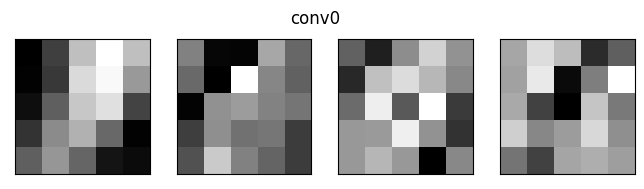

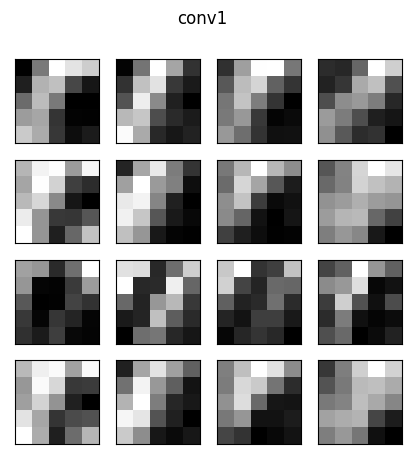

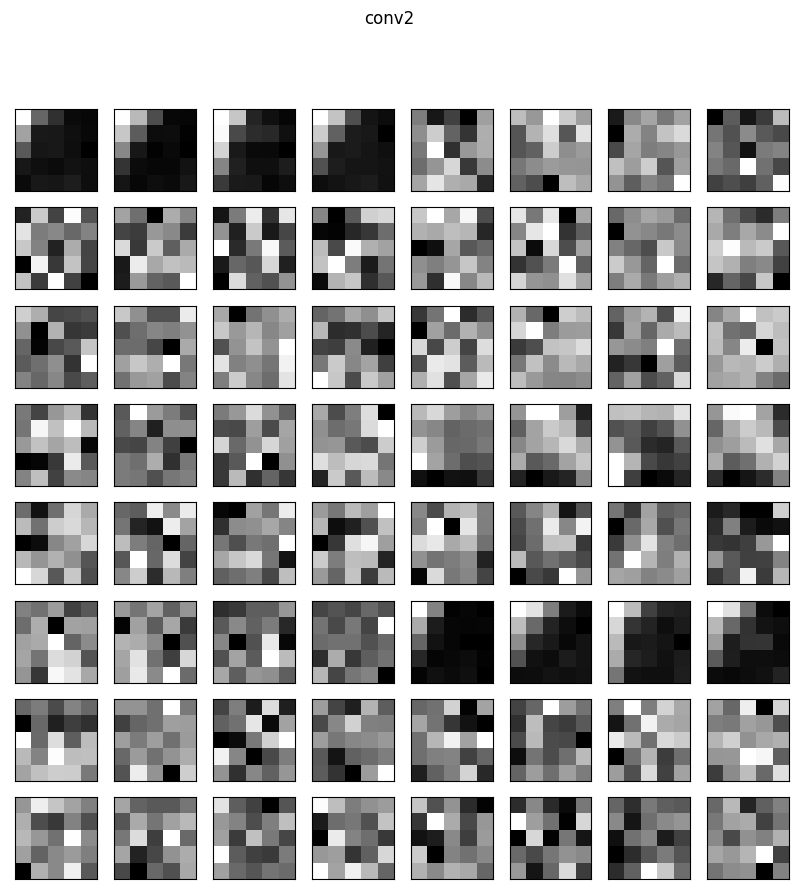

In [14]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(lane_keeper_ahead.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 1, 4, 'conv0', size=(8,2))

fig1 = plot_nchw_data(c1, 4, 4, 'conv1', size=(5,5)) 

fig2 = plot_nchw_data(c2, 8, 8, 'conv2', size=(10,10))



In [15]:
# CONVERT TO ONNX MODEL FOR OPENCV
lane_keeper_ahead.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models
import sys

device = torch.device('cpu')
lane_keeper_ahead.to(device)

# set the model to inference mode
lane_keeper_ahead.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, num_channels, SIZE[1], SIZE[0])
torch.onnx.export(lane_keeper_ahead, dummy_input, onnx_lane_keeper_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lane_keeper_ahead.to(device)

LaneKeeperAhead(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (12): ReLU(inplace=True)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)